<a href="https://colab.research.google.com/github/jjangmo91/Cervus-nippon_Anmado-Is./blob/main/Cervus-nippon_frtp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# Earth Engine Python API 모듈 및 라이브러리 호출
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from osgeo import gdal
import requests
import json
import geopandas as gpd
import os
import shutil
import psutil
from google.colab import drive
import zipfile

# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='ee-jjangmo91')

더 세밀한 NDVI분석을 위해 임상도의 FRTP 코드를 기준으로 분류하여 트렌드를 살펴봅니다.

In [ ]:
# GeoJSON 파일 URL
url_anmado = 'https://github.com/jjangmo91/Cervus-nippon_Anmado-Is./raw/main/anmado.geojson'
url_songido = 'https://github.com/jjangmo91/Cervus-nippon_Anmado-Is./raw/main/songido.geojson'

# GeoJSON 파일을 GEE FeatureCollection으로 변환하는 함수
def geojson_to_feature_collection(url):
    response = requests.get(url)
    geojson = response.json()
    features = []
    for feature in geojson['features']:
        geom = ee.Geometry(feature['geometry'])
        feat = ee.Feature(geom, feature['properties'])
        features.append(feat)
    return ee.FeatureCollection(features)

# FeatureCollection 생성
anmado_fc = geojson_to_feature_collection(url_anmado)
songido_fc = geojson_to_feature_collection(url_songido)

# 각 frtp 코드별 AOI 설정 및 NDVI 분석
frtp_values = ['0', '1', '2', '3']  # 문자열로 변경
results_anmado = []
results_songido = []

for frtp_value in frtp_values:
    # 속성 이름을 FRTP_CD로 수정하여 필터링 (문자열로 필터링)
    filtered_anmado_fc = anmado_fc.filter(ee.Filter.eq('FRTP_CD', frtp_value))
    filtered_songido_fc = songido_fc.filter(ee.Filter.eq('FRTP_CD', frtp_value))

    # 필터링된 FeatureCollection 크기 확인
    count_anmado = filtered_anmado_fc.size().getInfo()
    count_songido = filtered_songido_fc.size().getInfo()

    print(f"FRTP_CD {frtp_value} - Anmado Feature Count: {count_anmado}")
    print(f"FRTP_CD {frtp_value} - Songido Feature Count: {count_songido}")

    if count_anmado == 0 or count_songido == 0:
        print(f"FRTP_CD {frtp_value}에 대한 FeatureCollection이 비어 있습니다.")
        continue  # 다음 FRTP_CD 값으로 넘어감

    # AOI 설정: 경계 상자가 아닌 원래의 geometry 사용
    aoi_anmado = filtered_anmado_fc.geometry()
    aoi_songido = filtered_songido_fc.geometry()

    results_anmado.append((frtp_value, aoi_anmado))
    results_songido.append((frtp_value, aoi_songido))

In [45]:
# 색상 팔레트 설정 (FRTP_CD 값별로 색상을 지정)
colors = plt.cm.get_cmap('tab10', len(frtp_values)).colors  # 'tab10' 색상 팔레트 사용

# RGB 색상을 16진수 문자열로 변환하는 함수
def rgb_to_hex(rgb):
    return mcolors.to_hex(rgb)

# FRTP_CD 값에 따라 색상을 매핑
color_map = {frtp_value: rgb_to_hex(colors[idx]) for idx, frtp_value in enumerate(frtp_values)}

# 지도 객체 생성 및 AOI 시각화
Map = geemap.Map(center=[35.344031, 126.028111], zoom=12)

# 각 FRTP_CD에 대해 설정한 AOI를 시각화 (Anmado)
for frtp_value, aoi in results_anmado:
    if aoi is not None:
        Map.addLayer(aoi, {'color': color_map[frtp_value]}, f'Anmado AOI frtp {frtp_value}')

# 각 FRTP_CD에 대해 설정한 AOI를 시각화 (Songido)
for frtp_value, aoi in results_songido:
    if aoi is not None:
        Map.addLayer(aoi, {'color': color_map[frtp_value]}, f'Songido AOI frtp {frtp_value}')

# Anmado AOI 중심으로 설정
if results_anmado:
    Map.centerObject(results_anmado[0][1], 11)

# 지도 표시
Map

Map(center=[35.34933827590287, 126.01816083636925], controls=(WidgetControl(options=['position', 'transparent_…

In [48]:
# 구름 및 그림자 마스킹 함수 정의
def maskLandsatClouds(image):
    # QA_PIXEL 레이어 선택
    qa = image.select('QA_PIXEL')

    # 비트 마스킹을 통해 구름(clouds), 구름 그림자(cloud shadows), 눈(snow) 식별
    cloud = qa.bitwiseAnd(1 << 5)
    cloudShadow = qa.bitwiseAnd(1 << 3)
    snow = qa.bitwiseAnd(1 << 4)

    # 구름, 그림자, 눈이 없는 맑은 상태의 이미지 마스크 생성
    mask = cloud.eq(0).And(cloudShadow.eq(0)).And(snow.eq(0))

    # 마스크를 적용하고, 스케일 조정을 위해 결과를 10000으로 나눔
    return image.updateMask(mask).divide(10000)

# 모든 FRTP_CD 값에 대해 개별적으로 이미지 컬렉션을 필터링하고 저장
landsat5_images_anmado_by_frtp = {}
landsat5_images_songido_by_frtp = {}
landsat8_images_anmado_by_frtp = {}
landsat8_images_songido_by_frtp = {}

for frtp_value, aoi_anmado in results_anmado:
    # Landsat 5 이미지 컬렉션 필터링 및 마스킹 적용
    landsat5_images_anmado_by_frtp[frtp_value] = (
        ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
        .filterDate("1985-01-01", "2012-05-05")
        .filterBounds(aoi_anmado)
        .map(maskLandsatClouds)
    )
    # Landsat 8 이미지 컬렉션 필터링 및 마스킹 적용
    landsat8_images_anmado_by_frtp[frtp_value] = (
        ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
        .filterDate("2013-04-11", "2024-01-31")
        .filterBounds(aoi_anmado)
        .map(maskLandsatClouds)
    )

for frtp_value, aoi_songido in results_songido:
    # Landsat 5 이미지 컬렉션 필터링 및 마스킹 적용
    landsat5_images_songido_by_frtp[frtp_value] = (
        ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
        .filterDate("1985-01-01", "2012-05-05")
        .filterBounds(aoi_songido)
        .map(maskLandsatClouds)
    )
    # Landsat 8 이미지 컬렉션 필터링 및 마스킹 적용
    landsat8_images_songido_by_frtp[frtp_value] = (
        ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
        .filterDate("2013-04-11", "2024-01-31")
        .filterBounds(aoi_songido)
        .map(maskLandsatClouds)
    )

# 여기서 각 이미지 컬렉션에 대한 추가 분석 및 NDVI 계산을 수행할 수 있습니다.

In [51]:
# NDVI 계산 함수 정의 (Landsat 5)
def calculate_ndvi_landsat5(image):
    ndvi = image.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')  # B4: NIR, B3: RED
    return image.addBands(ndvi)

# NDVI 계산 함수 정의 (Landsat 8)
def calculate_ndvi_landsat8(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')  # B5: NIR, B4: RED
    return image.addBands(ndvi)

# NDVI 계산 적용 및 병합 (각 FRTP_CD 값에 대해)
all_ndvi_anmado_by_frtp = {}
all_ndvi_songido_by_frtp = {}

for frtp_value in frtp_values:
    if frtp_value in landsat5_images_anmado_by_frtp and frtp_value in landsat8_images_anmado_by_frtp:
        # Anmado 지역
        landsat5_images_anmado_ndvi = landsat5_images_anmado_by_frtp[frtp_value].map(calculate_ndvi_landsat5)
        landsat8_images_anmado_ndvi = landsat8_images_anmado_by_frtp[frtp_value].map(calculate_ndvi_landsat8)
        all_ndvi_anmado_by_frtp[frtp_value] = landsat5_images_anmado_ndvi.merge(landsat8_images_anmado_ndvi)

    if frtp_value in landsat5_images_songido_by_frtp and frtp_value in landsat8_images_songido_by_frtp:
        # Songido 지역
        landsat5_images_songido_ndvi = landsat5_images_songido_by_frtp[frtp_value].map(calculate_ndvi_landsat5)
        landsat8_images_songido_ndvi = landsat8_images_songido_by_frtp[frtp_value].map(calculate_ndvi_landsat8)
        all_ndvi_songido_by_frtp[frtp_value] = landsat5_images_songido_ndvi.merge(landsat8_images_songido_ndvi)

In [ ]:
import re

# 이미지 ID에서 날짜 추출하는 함수 (서버 측에서 실행)
def extract_date_from_id(image):
    img_id = image.get('system:index')
    date_str = ee.String(img_id).slice(-8)
    formatted_date = ee.Date.parse('yyyyMMdd', date_str).format('YYYY-MM-dd')
    return formatted_date

# AOI에 대한 NDVI 시계열 추출 (각 FRTP_CD 값에 대해)
ndvi_time_series_by_frtp = {}

for frtp_value in frtp_values:
    # Anmado 지역
    ndvi_timeseries_anmado = all_ndvi_anmado_by_frtp[frtp_value].map(
        lambda img: calculate_ndvi_time_series(img, results_anmado[frtp_values.index(frtp_value)][1])
    )

    # Songido 지역
    ndvi_timeseries_songido = all_ndvi_songido_by_frtp[frtp_value].map(
        lambda img: calculate_ndvi_time_series(img, results_songido[frtp_values.index(frtp_value)][1])
    )

    # 결과를 리스트로 변환
    ndvi_list_anmado = ndvi_timeseries_anmado.reduceColumns(ee.Reducer.toList(2), ['date', 'NDVI']).get('list').getInfo()
    ndvi_list_songido = ndvi_timeseries_songido.reduceColumns(ee.Reducer.toList(2), ['date', 'NDVI']).get('list').getInfo()

    # 데이터프레임 생성
    if len(ndvi_list_anmado) > 0 and len(ndvi_list_songido) > 0:
        dates_anmado, ndvi_values_anmado = zip(*ndvi_list_anmado)
        dates_songido, ndvi_values_songido = zip(*ndvi_list_songido)

        df_anmado = pd.DataFrame({'date': pd.to_datetime(dates_anmado), 'NDVI': ndvi_values_anmado})
        df_songido = pd.DataFrame({'date': pd.to_datetime(dates_songido), 'NDVI': ndvi_values_songido})

        # 날짜별로 중복된 값이 있을 경우 평균값으로 계산
        df_anmado_m = df_anmado.groupby('date', as_index=False).mean()
        df_songido_m = df_songido.groupby('date', as_index=False).mean()

        ndvi_time_series_by_frtp[frtp_value] = (df_anmado_m, df_songido_m)

        # NDVI 시계열 데이터 출력
        print(f"Anmado NDVI Time Series (FRTP_CD {frtp_value}, after averaging duplicates):")
        print(df_anmado_m.head())
        print(f"Songido NDVI Time Series (FRTP_CD {frtp_value}, after averaging duplicates):")
        print(df_songido_m.head())
    else:
        print(f"No valid NDVI data found for FRTP_CD {frtp_value} in Anmado or Songido.")

Anmado NDVI Time Series (FRTP_CD 0, after averaging duplicates):
        date      NDVI
0 1985-01-22  0.016934
1 1985-02-07  0.069580
2 1985-06-15  0.272494
3 1985-10-21  0.207811
4 1986-04-15  0.125106
Songido NDVI Time Series (FRTP_CD 0, after averaging duplicates):
        date      NDVI
0 1985-01-22  0.005746
1 1985-02-07  0.095271
2 1985-06-15  0.263448
3 1985-10-21  0.215649
4 1986-02-26  0.005042
Anmado NDVI Time Series (FRTP_CD 1, after averaging duplicates):
        date      NDVI
0 1985-01-22  0.065411
1 1985-02-07  0.106545
2 1985-06-15  0.300704
3 1985-10-21  0.249231
4 1986-04-15  0.143251
Songido NDVI Time Series (FRTP_CD 1, after averaging duplicates):
        date      NDVI
0 1985-01-22  0.014023
1 1985-02-07  0.133102
2 1985-06-15  0.316298
3 1985-10-21  0.235504
4 1986-02-26  0.006759
Anmado NDVI Time Series (FRTP_CD 2, after averaging duplicates):
        date      NDVI
0 1985-01-22  0.031943
1 1985-02-07  0.089454
2 1985-06-15  0.312239
3 1985-10-21  0.220370
4 1986

Anmado NDVI Time Series (after averaging duplicates):
        date      NDVI
0 1985-01-22  0.016934
1 1985-02-07  0.069580
2 1985-06-15  0.272494
3 1985-10-21  0.207811
4 1986-04-15  0.125106
Songido NDVI Time Series (after averaging duplicates):
        date      NDVI
0 1985-01-22  0.005746
1 1985-02-07  0.095271
2 1985-06-15  0.263448
3 1985-10-21  0.215649
4 1986-02-26  0.005042


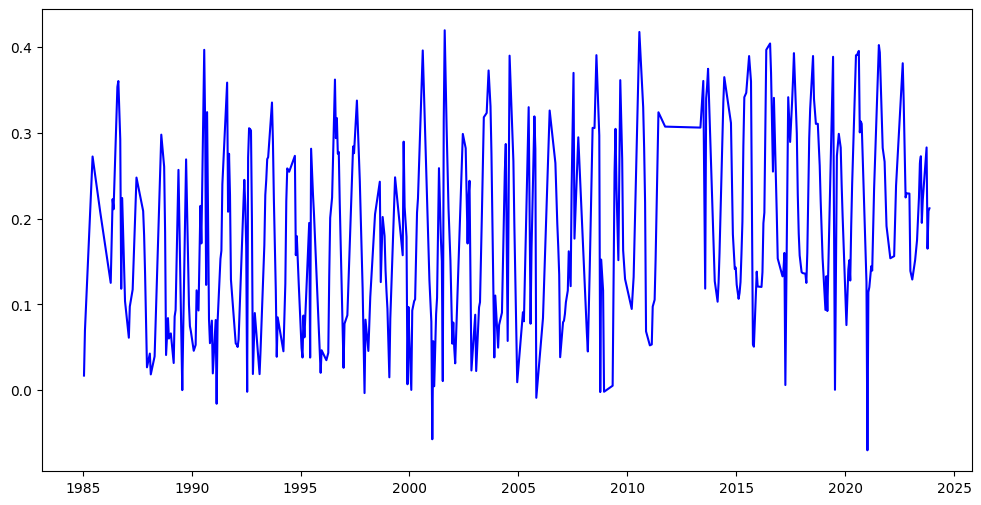

In [31]:
# 두 지역의 NDVI 시계열 비교 시각화 (각 FRTP_CD 값에 대해)
for frtp_value, (df_anmado_m, df_songido_m) in ndvi_time_series_by_frtp.items():
    if df_anmado_m is not None and df_songido_m is not None:
        plt.figure(figsize=(12, 6))

        # Anmado NDVI 시계열
        plt.plot(df_anmado_m['date'], df_anmado_m['NDVI'], label=f'Anmado FRTP_CD {frtp_value}', color='blue')

        # Songido NDVI 시계열
        plt.plot(df_songido_m['date'], df_songido_m['NDVI'], label=f'Songido FRTP_CD {frtp_value}', color='orange')

        # 그래프 타이틀 및 축 레이블 설정
        plt.title(f'NDVI Time Series: Anmado vs Songido (FRTP_CD {frtp_value})')
        plt.xlabel('Date')
        plt.ylabel('NDVI')
        plt.grid(True)

        # 범례 추가
        plt.legend()

        # 그래프 표시
        plt.show()

In [ ]:
# 기초 통계량 확인
statistics_anmado = df_anmado_m.describe()
print("Anmado 기초 통계량:\n", statistics_anmado)

statistics_songido = df_songido_m.describe()
print("Songido 기초 통계량:\n", statistics_songido)

Anmado 기초 통계량:
                                 date        NDVI
count                            424  424.000000
mean   2004-10-19 19:55:28.301886848   -0.022773
min              1985-01-22 00:00:00   -0.164031
25%              1994-06-16 00:00:00   -0.054793
50%              2003-12-18 00:00:00   -0.033254
75%              2015-10-12 00:00:00   -0.007726
max              2023-11-15 00:00:00    0.512509
std                              NaN    0.061174
Songido 기초 통계량:
                                 date        NDVI
count                            418  418.000000
mean   2004-06-22 10:40:45.933014400    0.106878
min              1985-01-22 00:00:00   -0.181629
25%              1994-05-11 00:00:00    0.040062
50%              2003-06-25 00:00:00    0.100261
75%              2015-04-11 00:00:00    0.175732
max              2023-11-15 00:00:00    0.354078
std                              NaN    0.098327


In [ ]:
# 결측치 확인
missing_values_anmado = df_anmado_m.isnull().sum()
print("Anmado 결측치:\n", missing_values_anmado)

missing_values_songido = df_songido_m.isnull().sum()
print("Songido 결측치:\n", missing_values_songido)

Anmado 결측치:
 date    0
NDVI    0
dtype: int64
Songido 결측치:
 date    0
NDVI    0
dtype: int64


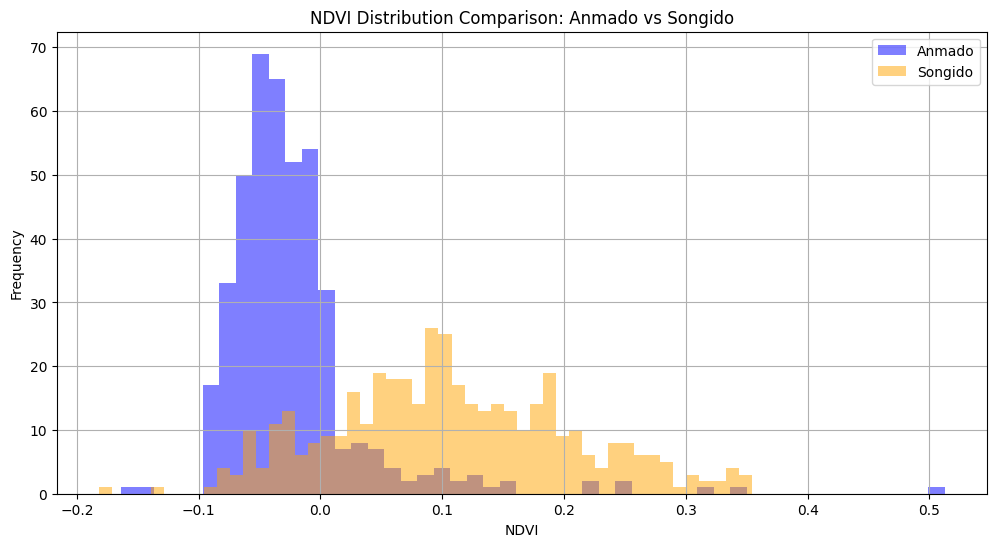

In [ ]:
plt.figure(figsize=(12, 6))

# Anmado 지역의 NDVI 분포
plt.hist(df_anmado_m['NDVI'], bins=50, alpha=0.5, label='Anmado', color='blue')

# Songido 지역의 NDVI 분포
plt.hist(df_songido_m['NDVI'], bins=50, alpha=0.5, label='Songido', color='orange')

# 그래프 타이틀 및 축 레이블 설정
plt.title('NDVI Distribution Comparison: Anmado vs Songido')
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.grid(True)

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

시계열 분석의 핵심은 데이터의 추세와 계절성을 파악하는 것입니다. 이를 위해 데이터의 이동 평균과 계절성을 시각화하고, 더 나아가 계절 분해를 통해 추세, 계절성, 불규칙성을 분리할 수 있습니다.

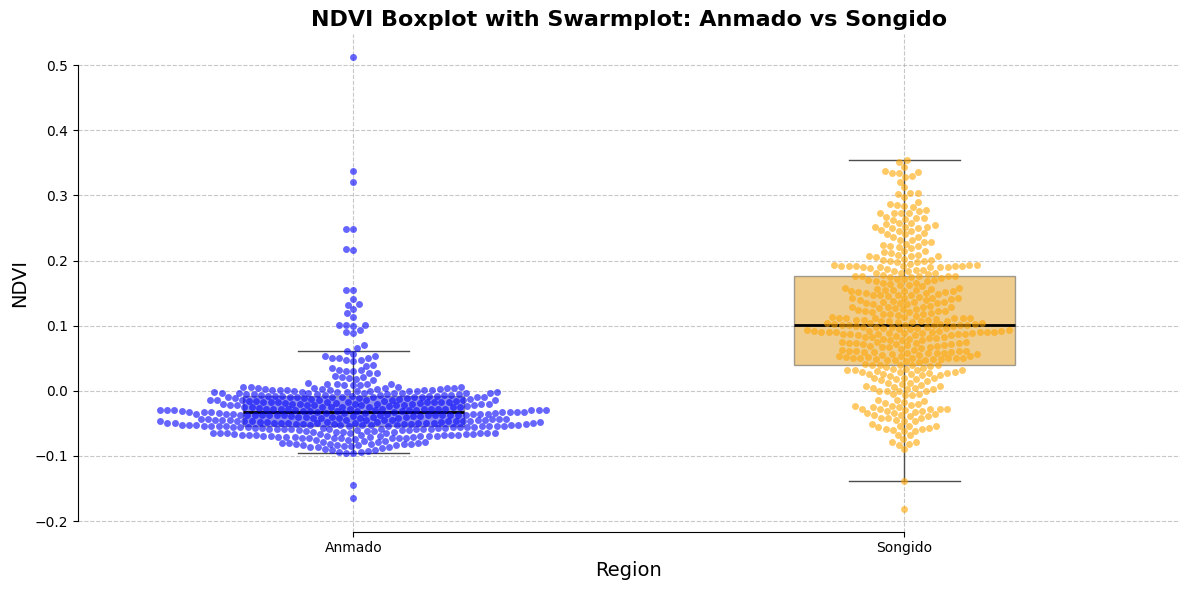

In [ ]:
plt.figure(figsize=(12, 6))

# Anmado 지역의 박스플롯
sns.boxplot(x=[0]*len(df_anmado_m), y=df_anmado_m['NDVI'], width=0.4, color='blue', fliersize=0, linewidth=1,
            boxprops=dict(alpha=0.5), medianprops=dict(color="black", linewidth=2))

# Songido 지역의 박스플롯
sns.boxplot(x=[1]*len(df_songido_m), y=df_songido_m['NDVI'], width=0.4, color='orange', fliersize=0, linewidth=1,
            boxprops=dict(alpha=0.5), medianprops=dict(color="black", linewidth=2))

# 데이터 포인트의 분포를 표시하기 위해 스웜플롯 추가 (겹쳐서 그리기)
sns.swarmplot(x=[0]*len(df_anmado_m), y=df_anmado_m['NDVI'], color='blue', alpha=0.6, size=5)
sns.swarmplot(x=[1]*len(df_songido_m), y=df_songido_m['NDVI'], color='orange', alpha=0.6, size=5)

# X축에 라벨 추가
plt.xticks([0, 1], ['Anmado', 'Songido'])

# 그래프 타이틀 및 축 레이블 설정
plt.title('NDVI Boxplot with Swarmplot: Anmado vs Songido', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=14)
plt.ylabel('NDVI', fontsize=14)

# 그래프의 스타일을 좀 더 깔끔하게
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine(trim=True)

# 그래프 표시
plt.tight_layout()
plt.show()

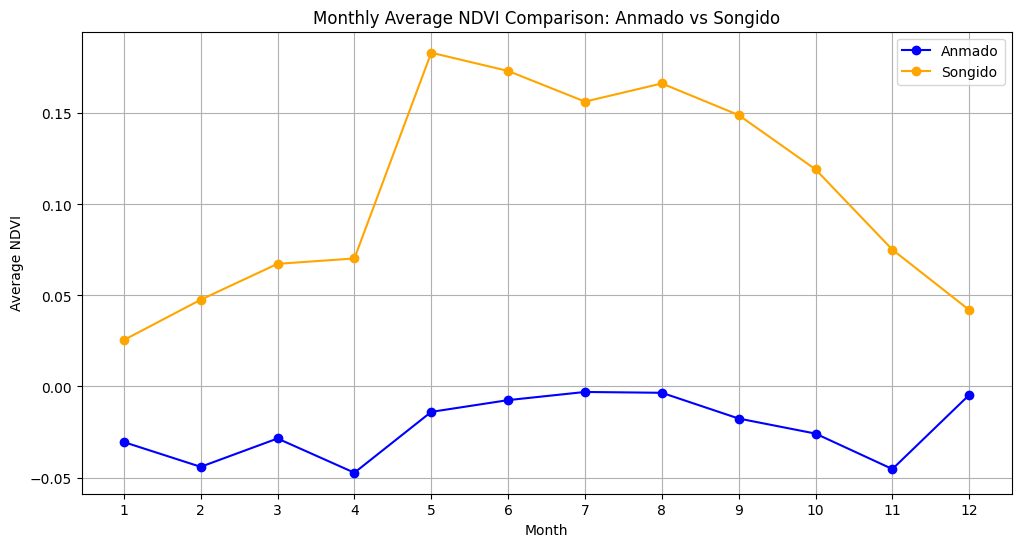

In [ ]:
# 월별 평균 NDVI 비교 시각화
plt.figure(figsize=(12, 6))

# Anmado 월별 평균 NDVI
plt.plot(monthly_avg_ndvi_anmado['month'], monthly_avg_ndvi_anmado['NDVI'], marker='o', label='Anmado', color='blue')

# Songido 월별 평균 NDVI
plt.plot(monthly_avg_ndvi_songido['month'], monthly_avg_ndvi_songido['NDVI'], marker='o', label='Songido', color='orange')

# 그래프 타이틀 및 축 레이블 설정
plt.title('Monthly Average NDVI Comparison: Anmado vs Songido')
plt.xlabel('Month')
plt.ylabel('Average NDVI')
plt.xticks(range(1, 13))  # 1월부터 12월까지
plt.grid(True)

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

In [ ]:
# IQR 계산을 통해 이상치 범위 결정
Q1_anmado = df_anmado_m['NDVI'].quantile(0.25)
Q3_anmado = df_anmado_m['NDVI'].quantile(0.75)
IQR_anmado = Q3_anmado - Q1_anmado

Q1_songido = df_songido_m['NDVI'].quantile(0.25)
Q3_songido = df_songido_m['NDVI'].quantile(0.75)
IQR_songido = Q3_songido - Q1_songido

# 이상치 제거 기준 설정
lower_bound_anmado = Q1_anmado - 1.5 * IQR_anmado
upper_bound_anmado = Q3_anmado + 1.5 * IQR_anmado

lower_bound_songido = Q1_songido - 1.5 * IQR_songido
upper_bound_songido = Q3_songido + 1.5 * IQR_songido

# 이상치를 제거한 데이터프레임 생성
df_anmado_cleaned = df_anmado_m[(df_anmado_m['NDVI'] >= lower_bound_anmado) & (df_anmado_m['NDVI'] <= upper_bound_anmado)]
df_songido_cleaned = df_songido_m[(df_songido_m['NDVI'] >= lower_bound_songido) & (df_songido_m['NDVI'] <= upper_bound_songido)]

print(f"Anmado 이상치 제거 전 데이터 수: {len(df_anmado_m)}")
print(f"Anmado 이상치 제거 후 데이터 수: {len(df_anmado_cleaned)}")

print(f"Songido 이상치 제거 전 데이터 수: {len(df_songido_m)}")
print(f"Songido 이상치 제거 후 데이터 수: {len(df_songido_cleaned)}")

Anmado 이상치 제거 전 데이터 수: 424
Anmado 이상치 제거 후 데이터 수: 398
Songido 이상치 제거 전 데이터 수: 418
Songido 이상치 제거 후 데이터 수: 417


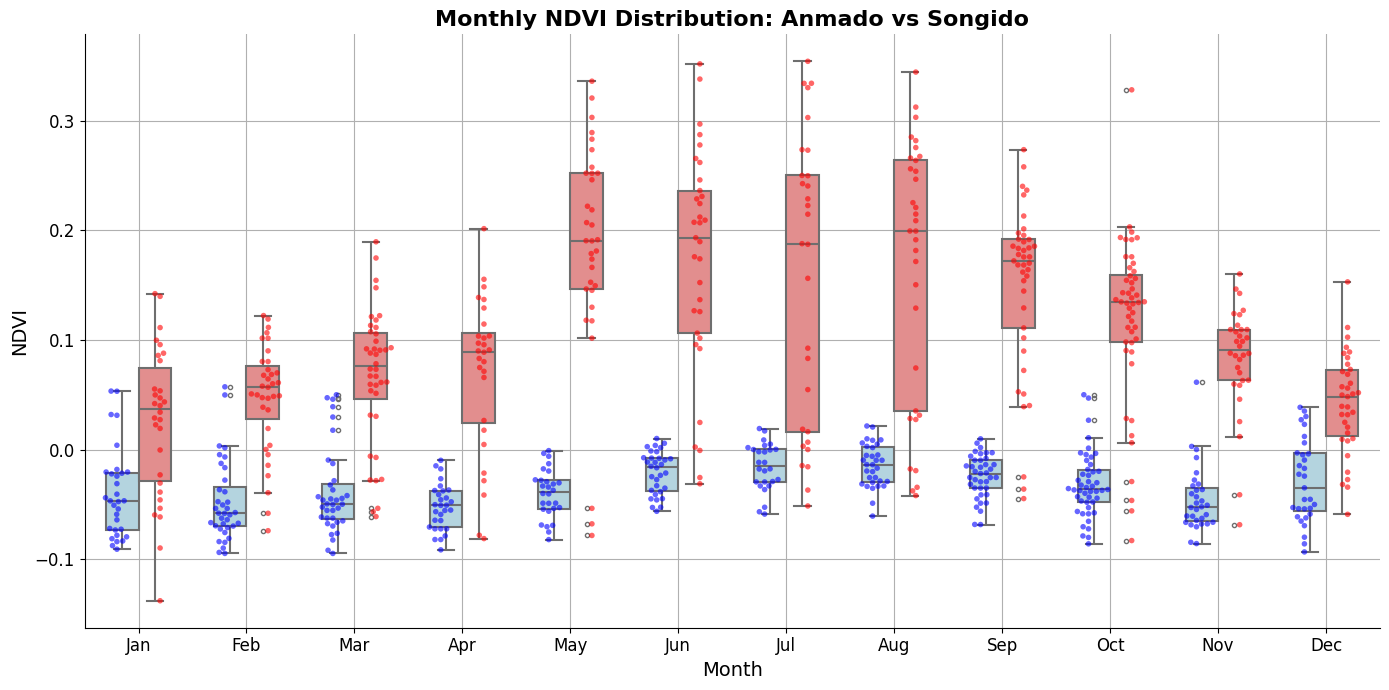

In [ ]:
# 월별로 그룹화하여 평균 계산
df_anmado_cleaned['month'] = df_anmado_cleaned['date'].dt.month
df_songido_cleaned['month'] = df_songido_cleaned['date'].dt.month

# Anmado와 Songido 데이터를 구분할 수 있도록 라벨 추가
df_anmado_cleaned['Region'] = 'Anmado'
df_songido_cleaned['Region'] = 'Songido'

# 두 지역의 데이터를 하나로 병합
df_combined = pd.concat([df_anmado_cleaned, df_songido_cleaned])

# X축이 1부터 12까지 모든 월을 포함하도록 조정
df_combined['month'] = pd.Categorical(df_combined['month'], categories=range(1, 13), ordered=True)

plt.figure(figsize=(14, 7))

# 박스플롯 시각화 (hue를 사용하여 구분)
sns.boxplot(x='month', y='NDVI', hue='Region', data=df_combined, palette=['lightblue', 'lightcoral'], width=0.6, fliersize=3, linewidth=1.5)

# 스웜플롯 추가 (데이터 포인트의 분포를 시각화)
sns.swarmplot(x='month', y='NDVI', hue='Region', data=df_combined, dodge=True, palette=['blue', 'red'], alpha=0.6, size=4)

# 그래프 타이틀 및 축 레이블 설정
plt.title('Monthly NDVI Distribution: Anmado vs Songido', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('NDVI', fontsize=14)

# X축 레이블 조정 (1월부터 12월까지)
plt.xticks(range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True)

# 레전드 추가 (위의 hue 인수로 이미 중복 추가된 레전드를 제거)
plt.legend([],[], frameon=False)

# 스타일 조정
sns.despine()

# 그래프 표시
plt.tight_layout()
plt.show()

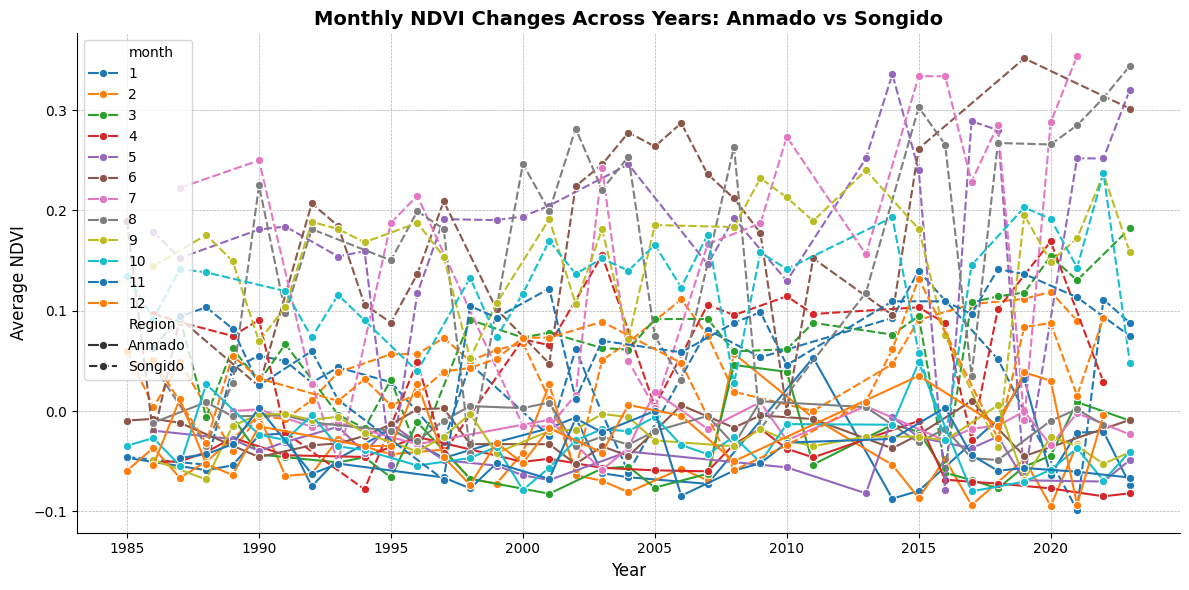

In [ ]:
# 연도와 월을 추출하여 새로운 열 생성
df_combined['year'] = df_combined['date'].dt.year
df_combined['month'] = df_combined['date'].dt.month

# 월별 연도별 지역별 평균 NDVI 계산
month_year_avg_ndvi = df_combined.groupby(['year', 'month', 'Region'])['NDVI'].mean().reset_index()

# 전체적인 연도별 월별 지역별 평균 NDVI 변화 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='NDVI', hue='month', style='Region', data=month_year_avg_ndvi, palette='tab10', marker='o')

# 그래프 타이틀 및 축 레이블 설정
plt.title('Monthly NDVI Changes Across Years: Anmado vs Songido', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average NDVI', fontsize=12)

# 스타일 조정
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()  # 박스라인 제거

# 그래프 표시
plt.tight_layout()
plt.show()

계절별로 살펴봅니다.

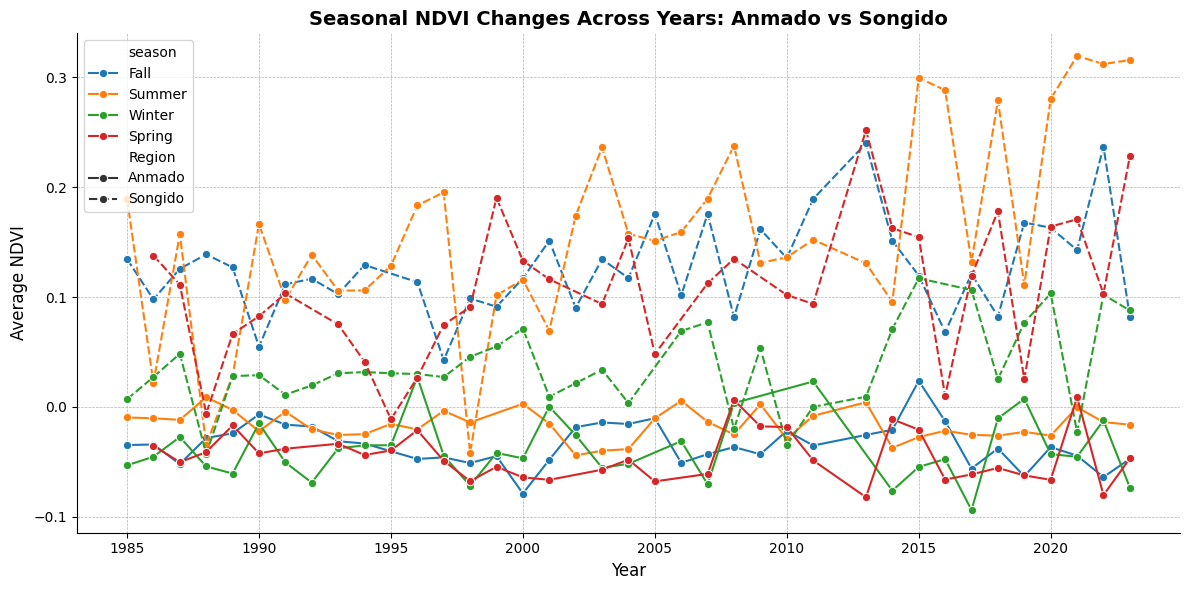

In [ ]:
# 연도와 월을 추출하여 새로운 열 생성
df_combined['year'] = df_combined['date'].dt.year
df_combined['month'] = df_combined['date'].dt.month

# 계절 정보 추가 함수 정의
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_combined['season'] = df_combined['month'].apply(get_season)

# 계절별 연도별 평균 NDVI 계산
season_year_avg_ndvi = df_combined.groupby(['year', 'season', 'Region'])['NDVI'].mean().reset_index()

# 전체적인 연도별 계절별 평균 NDVI 변화 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='NDVI', hue='season', style='Region', data=season_year_avg_ndvi, palette='tab10', marker='o')

# 그래프 타이틀 및 축 레이블 설정
plt.title('Seasonal NDVI Changes Across Years: Anmado vs Songido', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average NDVI', fontsize=12)

# 스타일 조정
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()  # 박스라인 제거

# 그래프 표시
plt.tight_layout()
plt.show()